#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [24]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

Read the spectral data

In [25]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [26]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

In [27]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


> Pivot the dataframe using WaveNumbers as features.

In [28]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

>Scale the absorbances to the highest peak in each spectrum.

In [29]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

>Scale the absorbances to the norm of the absorbances.

In [30]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

In [31]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=20)
    return(despiked_absorbance)

#df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [32]:
from pybaselines.whittaker import asls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        return corrected

#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [33]:
# # Best Full Spectrum Parameters

# lam = 10 ** 7
# p = 0.05
# window_size = 51
# poly_order = 2

# Best 400-1800 Parameters

lam = 10 ** 9
p = 0.01
window_size = 51
poly_order = 3

#### **Here is an example on 1 spectrum**

In [34]:
sample = df[df['SpecID'] == "201210-1-07"]
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

/tmp/ipykernel_107332/1811316291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

Subtract the baseline.

/tmp/ipykernel_107332/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

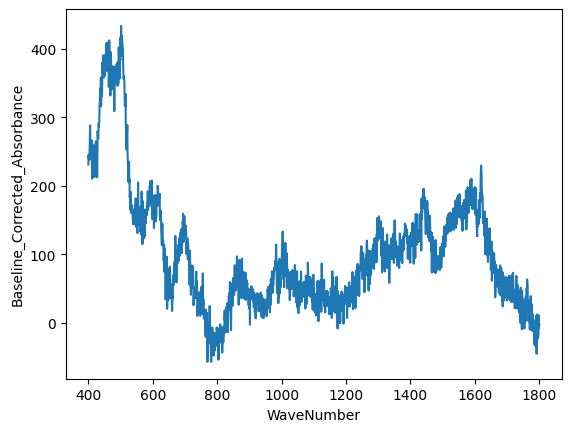

In [ ]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smooth the Baseline_Corrected_Spectrum

/tmp/ipykernel_107332/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

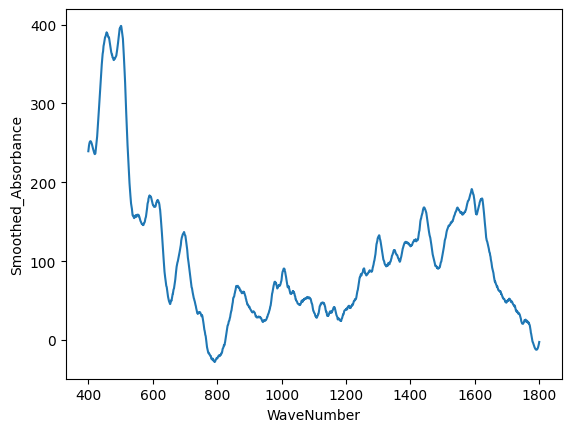

In [ ]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [ ]:
# # Despike

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [ ]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [ ]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df['Baseline']

In [ ]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
# Optional Scaling
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: vector_normalise(x))

In [ ]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1728.171994,37.490806,36.536980
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1728.001451,46.779449,36.477396
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1727.830907,41.199293,36.415312
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1727.660364,28.761636,36.351024
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1727.489820,31.379180,36.284828
...,...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1644.283309,-26.890709,-14.254770
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1643.635895,-10.544795,-13.647041
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1642.988482,-9.680882,-13.001735
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1642.341068,-0.474568,-12.318531


In [ ]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1728.171994,37.490806,36.536980
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1728.001451,46.779449,36.477396
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1727.830907,41.199293,36.415312
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1727.660364,28.761636,36.351024
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1727.489820,31.379180,36.284828
...,...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1644.283309,-26.890709,-14.254770
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1643.635895,-10.544795,-13.647041
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1642.988482,-9.680882,-13.001735
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1642.341068,-0.474568,-12.318531


In [ ]:
df = df.drop(columns=['Absorbance', 'Baseline', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [ ]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
293,201210-1-00,293,400.22778,201210-1,Normal,36.536980
294,201210-1-00,294,400.91116,201210-1,Normal,36.477396
295,201210-1-00,295,401.59454,201210-1,Normal,36.415312
296,201210-1-00,296,402.27789,201210-1,Normal,36.351024
297,201210-1-00,297,402.96127,201210-1,Normal,36.284828
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-14.254770
8023278,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-13.647041
8023279,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-13.001735
8023280,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-12.318531


In [ ]:
df.to_csv("../../data/current_clean_spectrum.csv", index=False)
# df.to_csv("../../data/400-1800_spike_removed.csv", index=False)